<a href="https://colab.research.google.com/github/carlaolivei/analise_sentimento/blob/main/analise_sentimento_avaliacao_restaurante.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Instalação do NLTK e pacote para geração de núvem de palavras</h1>

In [214]:
!pip install nltk
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [215]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h1> 1. SELEÇÃO do texto para pré-processaemnto</h1>

<h2> Importação, leitura e exploração do dataset</h2>

**Fonte do dataset**: https://www.kaggle.com/datasets/vigneshwarsofficial/reviews?resource=download

**Sobre o dataset**: o dataset contém 1.000 linhas e 2 colunas. A coluna "Review" contém comentários de clientes sobre restaurantes e a coluna "Liked" está preechida com 0 para comentários negativos e 1 para comentários positivos. 

**NOTA**: este notebook foi executado no Google Colab. Foi utilizada a URL abaixo para o download do arquivo "Restaurant_Reviews.tsv" que foi disponibilizado no sample_data, do Colab.

**Fonte do dataset**: https://www.kaggle.com/datasets/vigneshwarsofficial/reviews?resource=download

In [216]:
df = pd.read_csv('/content/sample_data/Restaurant_Reviews.tsv', sep='\t')
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [217]:
print("Shape:", df.shape)
print("\nInformações do dataset:\n")
print(df.info())
print("\nQuantidade de dados faltantes:\n")
print(df.isnull().sum())

Shape: (1000, 2)

Informações do dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
None

Quantidade de dados faltantes:

Review    0
Liked     0
dtype: int64


<h1> 2. PRÉ-PROCESSAMENTO do texto</h1>

<h2> Inclusão da coluna "Tamanho" dos comentários</h2>

In [218]:
df['Tamanho'] = df['Review'].apply(len)
print("Tamanho dos comentários:\n")
df.head()

Tamanho dos comentários:



,Review,Liked,Tamanho
0,Wow... Loved this place.,1,24
1,Crust is not good.,0,18
2,Not tasty and the texture was just nasty.,0,41
3,Stopped by during the late May bank holiday of...,1,87
4,The selection on the menu was great and so wer...,1,59


<h2> Gráfico de distribuição do tamanho dos comentários</h2>

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribuição do tamanho do texto')

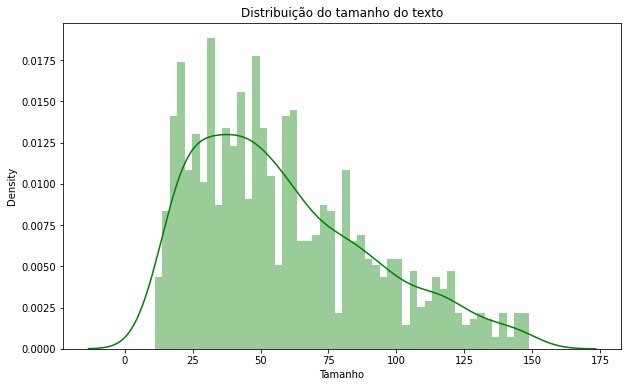

In [219]:
df_dist_grafico = plt.figure(figsize=(10,6))
sns.distplot(df['Tamanho'], kde=True, bins=50, color="green")
plt.title('Distribuição do tamanho do texto')

<h2> Gráfico de barra dos comentários negativos (0) e positivos (1)</h2>

In [220]:
#total da likes
total_likes = df['Liked'].count()
total_likes_0 = (df['Liked']==0).sum()
total_likes_1 = (df['Liked']==1).sum()
print("Total de likes:", total_likes)
print("Total de likes igual a 0:", total_likes_0)
print("Total de likes igual a 1:", total_likes_1)

Total de likes: 1000
Total de likes igual a 0: 500
Total de likes igual a 1: 500


Text(0, 0.5, 'count')

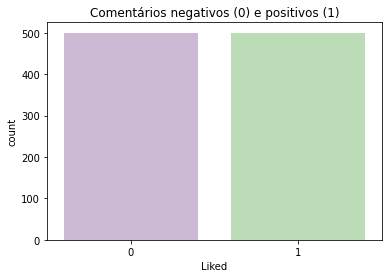

In [221]:
df_likes_grafico = sns.countplot(x='Liked', data=df, palette="PRGn")
df_likes_grafico.set_title('Comentários negativos (0) e positivos (1)')
df_likes_grafico.set_ylabel('count')

<h2> Stopword e remoção de pontuação </h2>

In [222]:
texto = df[['Review','Liked']]
texto['Tamanho'] = texto['Review'].apply(len)

In [223]:
stopWord = stopwords.words("english")

In [224]:
def remove_puntuacao_stopwords(texto):

    remove_puntacao = [word for word in texto.lower() if word not in string.punctuation]
    remove_puntacao = ''.join(remove_puntacao)
    return [word for word in remove_puntacao.split() if word not in stopWord]

In [225]:
texto_preprocessado = texto.copy()
texto_preprocessado['Review'] = texto['Review'].apply(remove_puntuacao_stopwords)
texto_preprocessado['Tamanho'] = texto_preprocessado['Review'].apply(len)
print("Tamanho dos comentários após aplicação do stopword:\n")
texto_preprocessado.head()

Tamanho dos comentários após aplicação do stopword:



,Review,Liked,Tamanho
0,"[wow, loved, place]",1,3
1,"[crust, good]",0,2
2,"[tasty, texture, nasty]",0,3
3,"[stopped, late, may, bank, holiday, rick, stev...",1,9
4,"[selection, menu, great, prices]",1,4


<h3> Gráfico de distribuição do tamanho dos comentários após STOPWORD</h3>

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribuição do tamanho do texto após aplicação de STOPWORD')

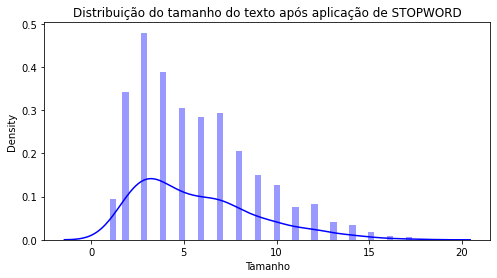

In [246]:
df_dist_grafico_processado = plt.figure(figsize=(8,4))
sns.distplot(texto_preprocessado['Tamanho'], kde=True, bins=50, color="blue")
plt.title('Distribuição do tamanho do texto após aplicação de STOPWORD')

<h3> Gráfico de frequência das palavras após Stopword</h3>

In [227]:
def grafico_frequencia(data):
    plt.figure(figsize=(10,5))
    FreqDist(np.concatenate(data.Review.reset_index(drop=True))).plot(25, cumulative=False, color="green")

Gráfico de frequência de comentários positivos (1):



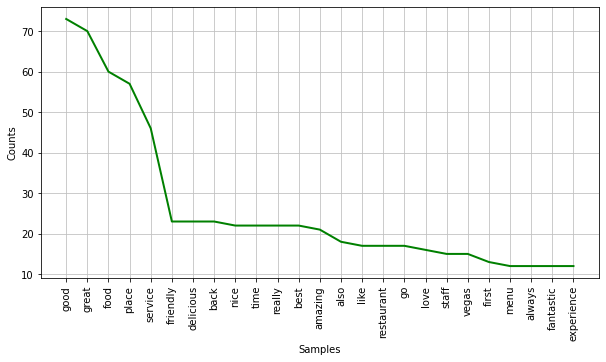

In [253]:
print("Gráfico de frequência de comentários positivos (1):\n")
grafico_frequencia(texto_preprocessado[texto_preprocessado['Liked']==1])

Gráfico de frequência de comentários negativos (0):



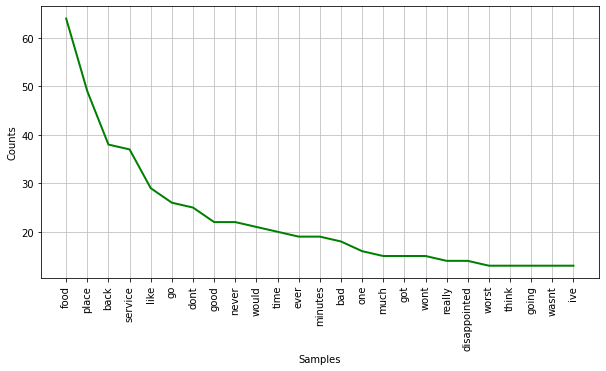

In [251]:
print("Gráfico de frequência de comentários negativos (0):\n")
grafico_frequencia(texto_preprocessado[texto_preprocessado['Liked']==0])

<h3> Nuvem de Palavras</h3>

In [230]:
def nuvem_palavras(Liked):
    Likedtexto = ' '.join(texto[texto['Liked']==Liked]['Review'])
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        colormap="hsv",
        stopwords = STOPWORDS).generate(str(Likedtexto))

    fig = plt.figure(
        figsize = (8, 4),
        facecolor = 'k',
        edgecolor = 'k',)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)

Nuvem de palavras para comentários postivos (1):



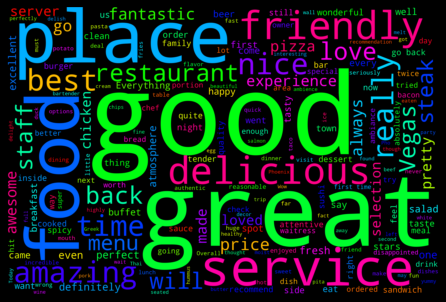

In [248]:
print("Nuvem de palavras para comentários postivos (1):\n")
nuvem_palavras(1)

Nuvem de palavras para comentários negativos (0):



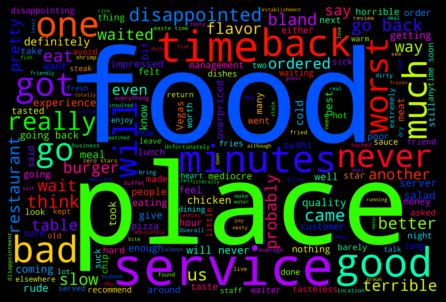

In [249]:
print("Nuvem de palavras para comentários negativos (0):\n")
nuvem_palavras(0)

<h1> 3. MINERAÇÃO do texto pré-processado</h1>

<h2>Definição das variáveis preditoras e do rótulo (resposta)</h2>

In [235]:
df_treinamento = texto[(texto['Liked']==1) | (texto['Liked']==0)]

In [236]:
#Definção das variáveis preditoras
x = df_treinamento['Review']
x.head()

0                             Wow... Loved this place.
1                                   Crust is not good.
2            Not tasty and the texture was just nasty.
3    Stopped by during the late May bank holiday of...
4    The selection on the menu was great and so wer...
Name: Review, dtype: object

In [237]:
#Definição do rótulo ou resposta
y = df_treinamento['Liked']
y.head()

0    1
1    0
2    0
3    1
4    1
Name: Liked, dtype: int64

<h2>Vetorização</h2>

In [238]:
vetorizar = CountVectorizer().fit(x)
x = vetorizar.transform(x)

In [239]:
print("Dimensões da matrix esparsa: ", x.shape)

Dimensões da matrix esparsa:  (1000, 2035)


<h2>Treinamento do Modelo</h2>

Separação dos dados para treinamento e dados para teste

In [240]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

<h2>Algoritmo MultinomialNB</h2>

Classificador Naive Bayes para modelos multinomiais. Este classificador é adequado para classificação com características discretas como, contagem de palavras para classificação de texto. A distribuição multinomial normalmente requer contagens de recursos inteiros. 
Fonte: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [241]:
mnb = MultinomialNB()

mnb.fit(x_train,y_train)
predicao_mnb = mnb.predict(x_test)

<h3>Métricas</h3>

In [255]:
print("Matriz de Confusão - Multinomial Naive Bayes:\n")
print(confusion_matrix(y_test,predicao_mnb))
print("\nRelatório de Classificação:",classification_report(y_test,predicao_mnb))

Matriz de Confusão - Multinomial Naive Bayes:

[[81 15]
 [26 78]]

Relatório de Classificação:               precision    recall  f1-score   support

           0       0.76      0.84      0.80        96
           1       0.84      0.75      0.79       104

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.79       200
weighted avg       0.80      0.80      0.79       200



Matriz de Confusão

In [243]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de Confusão',
                          cmap=plt.cm.Blues):
    """
    Esta função imprime e plota a matriz de confusão.
    A normalização pode ser aplicada definindo `normalize = True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada\n")
    else:
        print('Matriz de confusão sem normalização\n')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Matriz de confusão sem normalização

[[81 15]
 [26 78]]


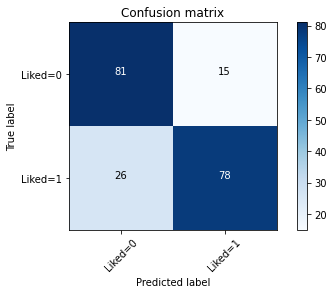

In [244]:
# Calculando a confusion matrix
matriz_confusao = confusion_matrix(y_test, predicao_mnb, labels=[0,1])
np.set_printoptions(precision=2)
# Imprimindo a matriz de confusão sem normalização
plt.figure()
plot_confusion_matrix(matriz_confusao, classes=['Liked=0','Liked=1'],normalize= False,  title='Confusion matrix')

<h1> 3. ASSIMILAÇÃO e aplicação do conhecimento gerado</h1>

Teste aplicando a previsão feito com base no modelo gerado

In [258]:
comentario = 'Terrific'
print("Cometário:", comentario)
print("*******************************************")
resultado = vetorizar.transform([comentario])
print("Classificação do comentário prevista:", mnb.predict(resultado)[0])
print("*******************************************")
print("LEGENDA: 0 = Negativo e 1 = Positivo")

Cometário: Terrific
*******************************************
Classificação do comentário prevista: 1
*******************************************
LEGENDA: 0 = Negativo e 1 = Positivo
